<a href="https://colab.research.google.com/github/Omid-Hassasfar/QIran-s-QProject-101_05-VQE/blob/main/5_VQE_BeH2_Beryllium_Hydride_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit[visulization]

  Using cached qiskit-0.43.2-py3-none-any.whl
  Using cached qiskit_terra-0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.9 MB)
  Using cached qiskit_aer-0.12.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.8 MB)
  Using cached qiskit_ibmq_provider-0.20.2-py3-none-any.whl (241 kB)
  Using cached requests_ntlm-1.1.0-py2.py3-none-any.whl (5.7 kB)
  Using cached websockets-11.0.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (129 kB)
  Using cached rustworkx-0.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.9 MB)
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Using cached stevedore-5.1.0-py3-none-any.whl (49 kB)
  Using cached symengine-0.9.2-cp310-cp310-manylinux2010_x86_64.whl (37.5 MB)
  Using cached ntlm_auth-1.5.0-py2.py3-none-any.whl (29 kB)
  Using cached cryptography-41.0.1-cp37-abi3-manylinux_2_28_x86_64.whl (4.3 MB)
  Using cached pbr-5.11.1-py2.py3-none-any.whl (1

In [ ]:
!pip install pyscf

  Using cached pyscf-2.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (47.2 MB)


In [ ]:
!pip install qiskit-nature

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 26.7 MB/s eta 0:00:00


In [ ]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.24.1', 'qiskit-aer': '0.12.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.2', 'qiskit-nature': '0.6.2', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [ ]:
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms.optimizers import SPSA, SLSQP
import numpy as np
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_aer.primitives import Estimator

---
---
# $Be-H_2$
---
---

In [ ]:
# Li-H Molecule
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=[ "H" , "Be", "H"],
        coords=([-dist, 0.0, 0.0] , [0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [ ]:
%%time

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.6, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

/usr/local/lib/python3.10/dist-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Interatomic Distance: 0.6 VQE Result: -14.40461 Exact Energy: -14.40506
Interatomic Distance: 0.7 VQE Result: -14.87061 Exact Energy: -14.87098
Interatomic Distance: 0.8 VQE Result: -15.17217 Exact Energy: -15.17247
Interatomic Distance: 0.9 VQE Result: -15.36356 Exact Energy: -15.36382
Interatomic Distance: 1.0 VQE Result: -15.48117 Exact Energy: -15.48142
Interatomic Distance: 1.1 VQE Result: -15.54905 Exact Energy: -15.54932
Interatomic Distance: 1.2 VQE Result: -15.58319 Exact Energy: -15.58348
Interatomic Distance: 1.3 VQE Result: -15.59436 Exact Energy: -15.59471
Interatomic Distance: 1.4 VQE Result: -15.58997 Exact Energy: -15.59040
Interatomic Distance: 1.5 VQE Result: -15.57514 Exact Energy: -15.57571
Interatomic Distance: 1.6 VQE Result: -15.55353 Exact Energy: -15.55428
Interatomic Distance: 1.7 VQE Result: -15.52776 Exact Energy: -15.52878
Interatomic Distance: 1.8 VQE Result: -15.49979 Exact Energy: -15.50121
Interatomic Distance: 1.9 VQE Result: -15.47112 Exact Energy: -1

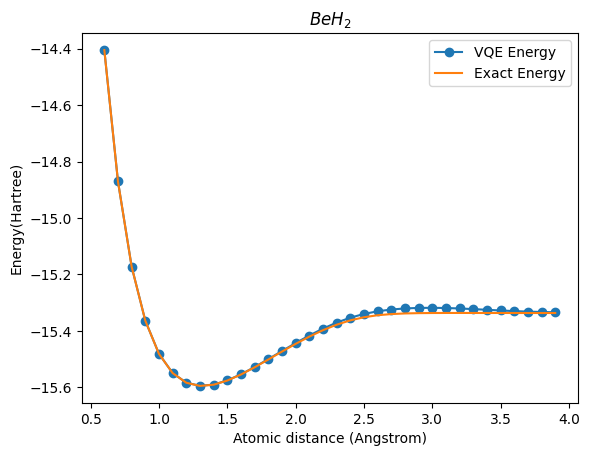

In [ ]:
plt.plot(distances, vqe_energies, 'o-' , label="VQE Energy")
plt.plot(distances, exact_energies, label="Exact Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy(Hartree)")
plt.title("$BeH_2$")
plt.legend()
plt.show()